# Getting started with `pythonradx`

`pythonradex` is used to solve the non-LTE radiative transfer in a 1D geometry. It can include effects of dust continuum and overlapping lines. Here we look at the main functionalities provided by pythonradex.

Note that all input and output for `pythonradex` is in SI units.

## Initialisation

In `pythonradex`, a radiative transfer calculation is conducted using the `Cloud` class thad is contained in the `radiative_transfer` module. Let's have a look how to initialise it. Please refer to the API for more details

In [1]:
from pythonradex import radiative_transfer,helpers
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt

We initialise an instance of the `Cloud` class, giving details for all available parameters:

In [2]:
# Filepath to the file containing molecular data. The file needs to follow the LAMDA format and is
#usually downloaded from the LAMDA database (https://home.strw.leidenuniv.nl/~moldata/)
datafilepath = './co.dat' #CO

#The geometry of the cloud. Please the documentation for more details. Available options: 'uniform sphere',
#'uniform sphere RADEX' (emulating RADEX, i.e. wrong flux calculation),'uniform slab', 'LVG slab',
#'LVG sphere', 'LVG sphere RADEX' (emulating RADEX)
geometry = 'uniform sphere'

#The shape of the intrinsic emission line profile. Available options: 'rectangular' and 'Gaussian'. Note that for LVG geometries, only
#rectangular is allowed
line_profile_type = 'Gaussian'

#The width of the emission line in velocity space. For a Gaussian, this corresponds to the FWHM. Note that pythonradex uses SI units,
#so this needs to be given in m/s
width_v = 1.5*constants.kilo #1500 m/s = 1.5 km/s

#additional available parameters, which we leave at their default values:

# - use_Ng_acceleration: Whether to use Ng acceleration to speed up convergence. Defaults to True.

# - treat_line_overlap: Whether to treat line overlap effects (i.e. emission lines that overlap in frequency).
#   This option is computationally expensive. Not allowed for LVG geometries. Defaults to False.
#   There is a dedicated example notebook demonstrating this capability.

# - warn_negative_tau: Whether to warn the user if negative optical depth occurs for any transition. Defaults to True.

# - verbose: Whether to print out additional info. Defaults to False.

# - test_mode: Whether to activate test mode. Only for developers, should be left to its default in general (False).

cloud = radiative_transfer.Cloud(
               datafilepath=datafilepath,geometry=geometry,
               line_profile_type=line_profile_type,width_v=width_v)

## Setting the cloud parameters

Next, we are going to set the parameters characterising the cloud physical conditions:

In [3]:
#The column density, in units of m-2
N = 1e14/constants.centi**2

#The kinetic temperature of the gas in units of K
Tkin = 120

#The number density of colliders, in dictionary format, in units of m-3. The following colliders are
#recognised: "H2", "para-H2", "ortho-H2", "e", "H", "He", "H+". Obviously, only colliders present
#in the data file can be used here. For CO, we can use para-H2 and ortho-H2
collider_densities = {'para-H2':1e4/constants.centi**3,'ortho-H2':3e4/constants.centi**3}

#The external background radiation. This is the radiation field that irradiates the cloud from the exterior and can
#affect the excitation conditions. The user can provide a custom radiation field by providing a function that takes
#a frequency array as input and returns the radiation field in units of #W/m2/Hz/sr. The commonly used CMB background
#can by used via the helpers module. One can also set this parameter to a number, which is interpreted as a constant
#value over frequency. So if no external background is desired, simply set this parameter to 0
#examples:
# def ext_background(nu):
    #return helpers.B_nu(nu=nu,T=200) # a black body at 200 K
#ext_background = 0 #no external background
ext_background = helpers.generate_CMB_background(z=1.3) #CMB at redshift 1.3

#Temperature and optical depth of the dust continuum radiation field, which is internal to the cloud (i.e. the dust is mixed with the gas).
#The dust temperature defines the source function of the field by setting it equal to the Planck law (black body)
#The user can provide custom T_dust and tau_dust functions, which should take an array of frequencies as input.
#One can als provide a number, which is interpreted as constant value. Thus, to ignore dust, simply put both parameters to 0
#There is a dedicated notebook discussing dust effects
#examples:
#def T_dust(nu):
#    nu0 = 100*constants.giga #some reference frequency
#    return 100*(nu/nu0) # dust temperature proportional to frequency
#T_dust = 80 #constant dust temperature for all frequencies
#tau_dust = 0.05 #constant optical depth for all frequencies
T_dust, tau_dust = 0,0 #no dust

#all of these parameters need to be specified when update_parameters is called for the first time
#later, we can use the same function to only update a subset of parameters
cloud.update_parameters(N=N,Tkin=Tkin,collider_densities=collider_densities,
                        ext_background=ext_background,T_dust=T_dust,tau_dust=tau_dust)

## Solve the radiative transfer

Next, we solve the radiative transfer (i.e. calculate the level population with an iterative method)

In [4]:
cloud.solve_radiative_transfer()

## Inspect the results

### Level population, excitation temperature, optical depth at $\nu_0$

Let's inspect some basic results of the calculation: the level population, excitation temperature and optical depth at the rest frequency

In [5]:
#fractional level population of the 2rd and 5th levels (as listed in the LAMDA file), thus indices are 1 and 4
level_indices = (1,4)
for i in level_indices:
    level_pop = cloud.level_pop[i]
    print(f'fractional population of level {i}: {level_pop:.2g}')
#find the level with the highest fractional population:
most_populated_level = np.argmax(cloud.level_pop)
max_level_pop = np.max(cloud.level_pop)
print(f'level {most_populated_level} is the most populated (fractional level population = {max_level_pop:.3g})')

fractional population of level 1: 0.11
fractional population of level 4: 0.19
level 3 is the most populated (fractional level population = 0.21)


The optical depth at the rest frequency $\nu_0$ does not include the contribution of dust or overlapping lines; it is just the optical depth of the request transition, not the total optical depht.

In [6]:
# let's consider the 3st and 6st transition in the LAMDA file (CO 3-2 and CO 6-5), with indices 2 and 5
transition_indices = (2,5)
for i in transition_indices:
    tau_nu0 = cloud.tau_nu0_individual_transitions[i]
    Tex = cloud.Tex[i]
    print(f'transition {i}: Tex = {Tex:.3g} K, tau_nu0 = {tau_nu0:.3g}')

transition 2: Tex = 103 K, tau_nu0 = 0.00149
transition 5: Tex = 44.8 K, tau_nu0 = 0.00365


### Fluxes of transitions

Let's first look at the flux of some transitions we are interested in. For example, imaging we are interested in CO 1-0 and CO 4-3. In the LAMDA file, these two transitions appear in 1st and 4st position, so their indices are 0 and 3. Note that this calculation is only possible if the dust is optically thin. Similarly, for overlapping lines, the calculation is only possible if all overlapping lines are optically thin.

We also need to define the solid angle of the source.

In [7]:
flux_transitions = [0,3] #the indices of the transitions we want the flux for
R = 10*constants.au #assume our sphere has a radius of 10 au
distance = 100*constants.parsec #assume the source is at a distance of 100 pc
solid_angle = R**2*np.pi/distance**2

fluxes = cloud.fluxes_of_individual_transitions(transitions=flux_transitions,solid_angle=solid_angle)
for index,f in zip(flux_transitions,fluxes):
    print(f'flux of transition {index}: {f:.3g} W/m2')

flux of transition 0: 2.41e-26 W/m2
flux of transition 3: 1.41e-23 W/m2


### Spectrum and total optical depth

We can also request a spectrum of emission (flux as function of frequency) and the total optical depth at arbitrary frequencies. It is often easiest to define a range of velocities and convert it to a frequency range.

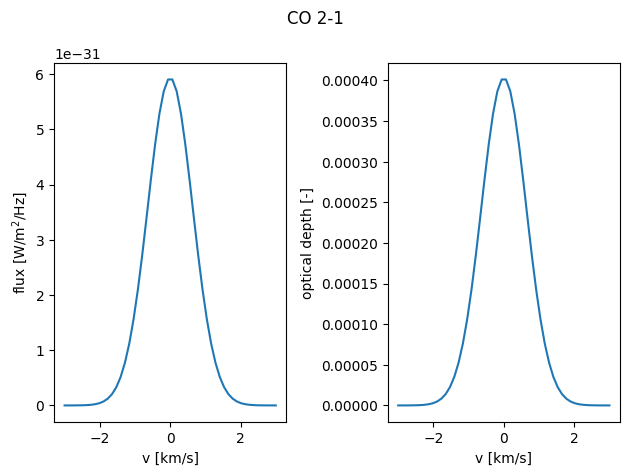

In [8]:
v = np.linspace(-2*width_v,2*width_v,50) #m/s
#retrieve the rest frequency of CO 2-1
nu0 = cloud.emitting_molecule.nu0[1] #Hz
nu = nu0*(1-v/constants.c) #Hz
tau_nu = cloud.tau_nu(nu=nu) #total optical depth as function of nu
spectrum = cloud.spectrum(nu=nu,solid_angle=solid_angle) #spectrum of CO 2-1

fig,axes = plt.subplots(ncols=2)
fig.suptitle('CO 2-1')
axes[0].plot(v/constants.kilo,spectrum)
axes[0].set_ylabel(r'flux [W/m$^2$/Hz]')
axes[1].plot(v/constants.kilo,tau_nu)
axes[1].set_ylabel('optical depth [-]')

for ax in axes:
    ax.set_xlabel('v [km/s]')
fig.tight_layout()

### printing an overview of the results

An overview of the results can be printed to the console. For each transition, it lists the indices of the upper and lower level, the rest frequency, the excitation temperature, the fractional population of the lower and upper level, and the optical depth of the transition at the rest frequency

In [9]:
cloud.print_results()



  up   low      nu0 [GHz]    T_ex [K]      poplow         popup         tau_nu0
   1    0     115.271202     339.01      0.0379612        0.11204    5.82035e-05
   2    1     230.538000     188.53        0.11204        0.17609     0.00040302
   3    2     345.795990     102.69        0.17609       0.209737      0.0014917
   4    3     461.040768      65.53       0.209737       0.192387     0.00324338
   5    4     576.267931      50.52       0.192387       0.136013     0.00424651
   6    5     691.473076      44.76       0.136013        0.07659      0.0036521
   7    6     806.651806      43.15        0.07659      0.0360304     0.00229127
   8    7     921.799700      43.66      0.0360304      0.0148235     0.00114472
   9    8    1036.912393      45.30      0.0148235     0.00552344    0.000487533
  10    9    1151.985452      47.50     0.00552344     0.00190625    0.000185507
  11   10    1267.014486      50.14     0.00190625    0.000620812    6.48427e-05
  12   11    1381.995105   

## Change the cloud parameters

We can update the cloud parameters for another calculation. We can update a single parameter, or several parameters at the same time. We can update the column density, kinetic gas temperature, collider densities, external background, dust temperature and dust optical depth.

For example, let's change the kinetic temperature and solve again:

In [10]:
new_Tkin = 20
cloud.update_parameters(Tkin=new_Tkin)
cloud.solve_radiative_transfer()

for i in transition_indices:
    tau_nu0 = cloud.tau_nu0_individual_transitions[i]
    Tex = cloud.Tex[i]
    print(f'transition {i}: Tex = {Tex:.3g} K, tau_nu0 = {tau_nu0:.3g}')

transition 2: Tex = 16.7 K, tau_nu0 = 0.011
transition 5: Tex = 14.2 K, tau_nu0 = 0.000396


The excitation temperatures are now much lower.

## Run a grid of models

`pythonradex` provides a convenience function to run a grid of models. Please see the corresponding example notebook.